<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Best_Buy_Logo.svg" alt="bb logo" width="100"/>

<h1><FONT COLOR=#0000E5>BESTBUY </FONT>Televisions</h1>

## 📉 Data Analysis <SPAN STYLE="font-size:18.0pt;font-family:Georgia;">III</span>
### Customer Brand <FONT COLOR=#0000E5>Loyalty</FONT> & <FONT COLOR=#0000E5>Price Sensitivity</FONT>?

In [47]:
import requests
import json
import numpy as np
import pandas as pd
from python_proj.spiders.myAPIkey import getkey

In [2]:
myAPIkey = getkey()
url_head = "https://api.bestbuy.com/v1/products/"  # obtained from https://developer.bestbuy.com/
endpoint = "/viewedUltimatelyBought?"

In [3]:
# Load in list of product sku #s to request
bb = pd.read_csv('python_proj\\bb_clean.csv')
bb = bb.set_index('sku')

In [5]:
### Try test GET ###
sku = '6466022'
url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
res = requests.get(url=url_full)
json.loads(res.content)['results'][0]['sku']

'6296602'

### For each TV, take sku# and make request for <FONT COLOR=#0000E5>Viewed Ultimately Bought</FONT> Products
"Viewed Ultimately Bought Products endpoint can be used to identify the ***top ten products*** that were bought after having viewed the originating product."

In [110]:
# time package for random pausing during API get
import time

In [111]:
#initialte dict to collect all get results
get_full = {}

In [112]:
"""
Takes 10 mins to complete!!
"""

for sku in bb.index:  # replace with [6466022,6414244,6461913,6466017,5900939] or bb.index
    """
    Loop through sku #s and request associated "Viewed Ultimately Bought" product skus
    Save request.content as dictionary (dict.update each request)
    """
    url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
    res = requests.get(url=url_full)
    res_content = json.loads(res.content)['results']
    
    # convert response to dict entry
    get_entry = {sku:[res_content[i]['sku'] for i in range(len(res_content))]}
    
    # if response does not return 10 results, fill in NaN up to 10
    dist_from_10 = 10 - len([*get_entry.values()][0])
    [[*get_entry.values()][0].append(np.nan) for i in range(dist_from_10)]
    
    # append dict entry
    get_full.update(get_entry)
    
    time.sleep(np.random.rand()) # random pause between each request

### After API pull, place result dictionary into pd.DataFrame

In [130]:
u_bought = pd.DataFrame.from_dict(get_full).T
u_bought.index.rename('sku',inplace=True)
u_bought.columns = [f'bu{i}' for i in range(1,11)]

In [138]:
# save raw results to csv
u_bought.to_csv('python_proj\\u_bought_raw.csv')

In [200]:
# Check results
assert u_bought.shape[0] == bb.shape[0] == 397, "Pulled rows of data should equal # of products in bb_clean (397)"

In [199]:
"""
Prepare data for merge: 
1. melt into single column
2. rename column 
3. drop unused column
4. drop Nan rows
5. ub_sku column dtype should be set to int64 or else merge raises Error
"""
ub_clean = pd.melt(u_bought.reset_index(), id_vars=['sku'],value_vars=[f'bu{i}' for i in range(1,11)])
ub_clean = ub_clean.set_index('sku')
ub_clean.rename(columns={'value':'ub_sku'}, inplace=True)
ub_clean.drop(columns='variable', inplace=True)
ub_clean.dropna(how='any',inplace=True)
ub_clean['ub_sku'] = ub_clean['ub_sku'].astype('int64')
ub_clean.shape  #from 3970 to 3787

(3787, 1)

### Now we can merge with original bb data to obtain the bought TV brand & price

- merge once on index to get originating TV price and manuf
- merge once on ub_sku to get ultimately bought TV price and manuf

In [218]:
ub_final = ub_clean.merge(bb,how='left',left_on='sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'orig_brand','regular_px':'orig_px'}, inplace=True)

In [220]:
ub_final = ub_final.merge(bb,how='left',left_on='ub_sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'ub_brand','regular_px':'ub_px'}, inplace=True)

In [230]:
ub_final.ub_brand.loc[ub_final.ub_brand.isna()].shape  # out of 3787, only 86 were not TV purchases

(86,)

In [256]:
ub_pxdiffs = ub_final.groupby('sku').mean()[['orig_px','ub_px']]

In [257]:
ub_pxdiffs['px_diffs'] = ub_pxdiffs.orig_px - ub_pxdiffs.ub_px

In [258]:
ub_pxdiffs.px_diffs.describe()

count      381.000000
mean       418.630367
std       1295.167675
min       -535.000000
25%        -38.000000
50%         23.000000
75%        230.000000
max      11000.000000
Name: px_diffs, dtype: float64

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [260]:
n_plots = 10
sns.set_palette(sns.color_palette("cividis", n_plots), n_plots)

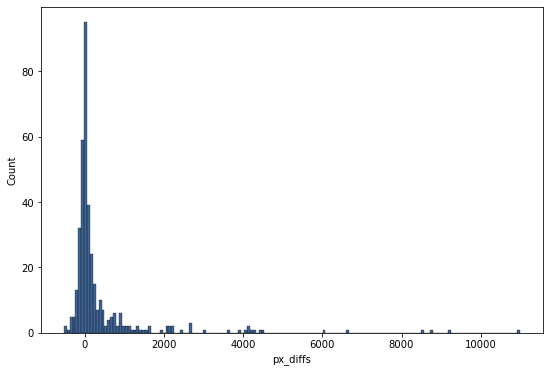

In [261]:
fig = plt.gcf()
fig.set_size_inches(9,6)
sns.histplot(ub_pxdiffs['px_diffs'])
plt.show()